Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression

Load Data:

For the training set, it's provides the outcome for each passenger.

For the testing set, it's not provides the ground truth for each passenger. It use to predict these outcomes. For each passenger, use the model to predict whether or not a passenger survived the sinking of the Titanic.

In [2]:
df_train = pd.read_csv('./data/titanic.csv')
df_test = pd.read_csv('./data/titanic_test.csv')

Data Review

Notes:

Survived: 0 = Deceased, 1 = Survived

sibsp: # of siblings / spouses aboard the Titanic (The dataset defines family relations in this way...)

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: # of parents / children aboard the Titanic (The dataset defines family relations in this way...)

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Text(0.5, 1.0, 'Fare Count')

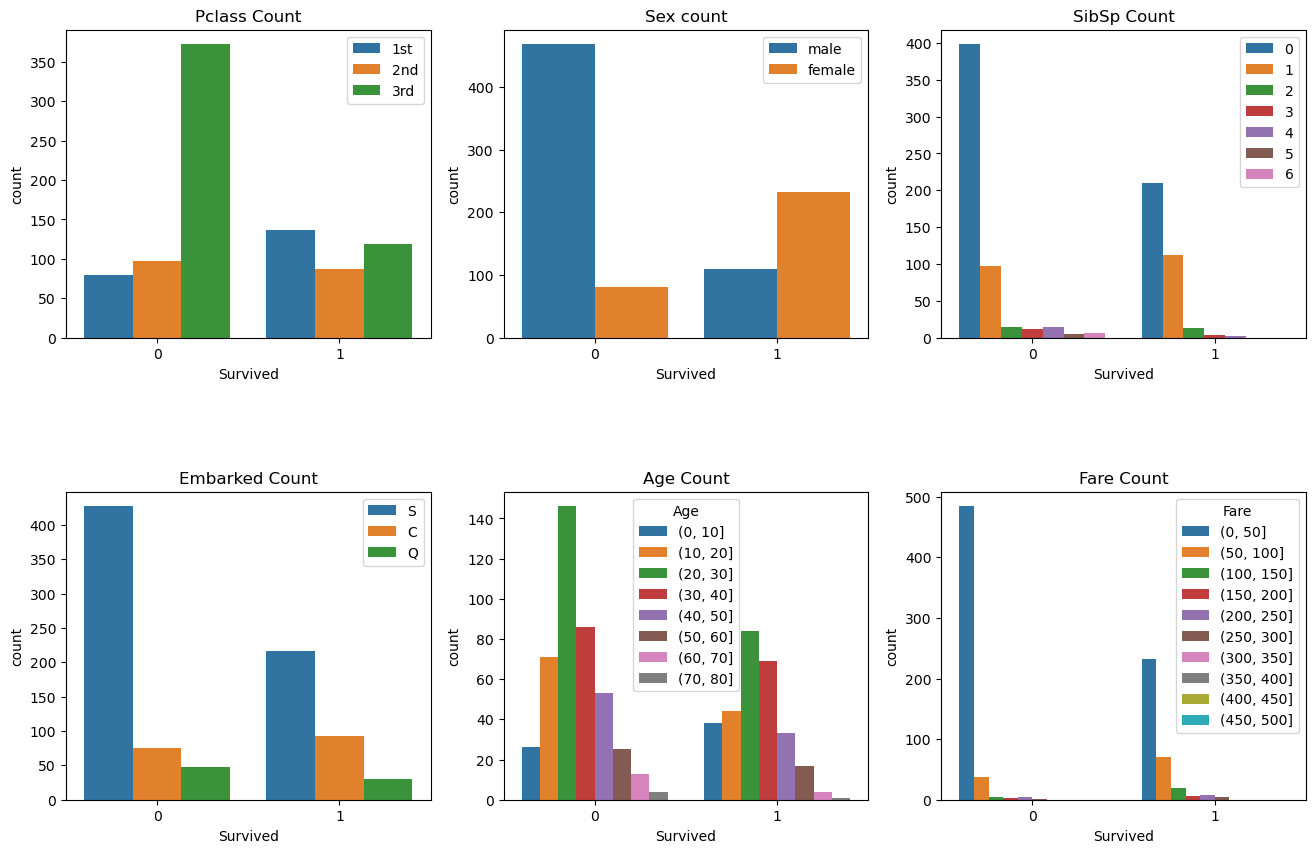

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# the ratio of survived people in each class (1st, 2nd, 3rd)
sns.countplot(x='Survived', hue='Pclass', data=df_train, ax=ax[0, 0])
pclass_legend = ['1st', '2nd', '3rd']
ax[0, 0].legend(pclass_legend)
ax[0, 0].set_title('Pclass Count')

sns.countplot(x='Survived', hue='Sex', data=df_train, ax=ax[0, 1])
sex_legend = ['male', 'female']
ax[0, 1].legend(sex_legend)
ax[0, 1].set_title('Sex count')

sns.countplot(x='Survived', hue='SibSp', data=df_train, ax=ax[0, 2])
sibsp_legend = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
ax[0, 2].legend(sibsp_legend)
ax[0, 2].set_title('SibSp Count')

# the ratio of survived people with embarked
sns.countplot(x='Survived', hue='Embarked', data=df_train, ax=ax[1, 0])
embarked_legend = ['S', 'C', 'Q']
ax[1, 0].legend(embarked_legend)
ax[1, 0].set_title('Embarked Count')

# the ratio of survived people with age group
age_group = [0, 10, 20, 30, 40, 50, 60, 70, 80]

sns.countplot(x='Survived', hue=pd.cut(df_train['Age'], age_group), data=df_train, ax=ax[1, 1])
ax[1, 1].set_title('Age Count')

# the ratio of survived people with fare group
fare_group = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
sns.countplot(x='Survived', hue=pd.cut(df_train['Fare'], fare_group), data=df_train, ax=ax[1, 2])
ax[1, 2].set_title('Fare Count')

Check the missing values of each columns in the training set

In [7]:
# Count missing value
for i in df_train.columns:
    print(i + " - "+ str(df_train[i].isnull().sum()))

PassengerId - 0
Survived - 0
Pclass - 0
Name - 0
Sex - 0
Age - 177
SibSp - 0
Parch - 0
Ticket - 0
Fare - 0
Cabin - 687
Embarked - 2


You can see we have 3 columns with incomplete values: age has 177 missing lines, cabin has 687 lines, embarked has 2 lines missing

Categorical: `Survived`, `Sex`, `Embarked`, `Pclass`, `Sibsp`, `Parch`

Numerical: `Age`, `Fare`

Mix types of data: `Ticket`, `Cabin`

Contain Error/ Typo: `Name`

Blank or Null: `Cabin` > `Age` > `Embarked`

Base on the analysis, some features are not relevant to the result. So we can drop that features without affecting the results. And we must drop in both the training set (df_train) and the testing set (df_test)

We can drop Ticket and Cabin columns

In [8]:
df_train = df_train.set_index(df_train.PassengerId)
df_train = df_train.drop('PassengerId', axis=1)
df_test = df_test.set_index(df_test.PassengerId)
df_test = df_test.drop('PassengerId', axis=1)
df_train = df_train.drop(['Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin'], axis=1)
df = [df_train, df_test]

Convert Categorical features

Because the `Sex` and `Embarked` column is of Categorical type, we will convert it to numberical as follows:

with `Sex` column:

`male` = 0

`female` = 1

with the `Embarked` column because it lacks a value, we fill in `NaN` the value of the area with the highest survival rate:

`Southampton` (S) = 0

`Cherbourg` (C) = 1

`Queenstown` (Q) = 2

In [9]:
for df in [df_train, df_test]:
    df['Sex'] = df['Sex'].map({'male':0,'female':1}).astype(int)
    df['Embarked'] = df['Embarked'].fillna(df_train['Embarked'].mode()[0])
    df['Embarked'] = df['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0


Continue, before we drop Name features, we will replace the Name features with Title, we will have the following types: Miss, Mrs, Mr, Master, Rare (including Name features that rarely appear). After convert it to numberical.

Mr = 0, Miss = 1, Mrs = 2, Master = 3, Rare = 4 and fill NaN rows = 5

In [10]:
for df in [df_train, df_test]:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Dr','Major','Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Rare':4}).astype(int)
    df['Title'] = df['Title'].fillna(5)

The training set after convert Title, Sex, Embarked

In [11]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1,2
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0,2
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0,0


Now, let's drop Name column.

In [12]:
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,0
2,1,1,1,38.0,1,0,71.2833,1,2
3,1,3,1,26.0,0,0,7.9250,0,1
4,1,1,1,35.0,1,0,53.1000,0,2
5,0,3,0,35.0,0,0,8.0500,0,0


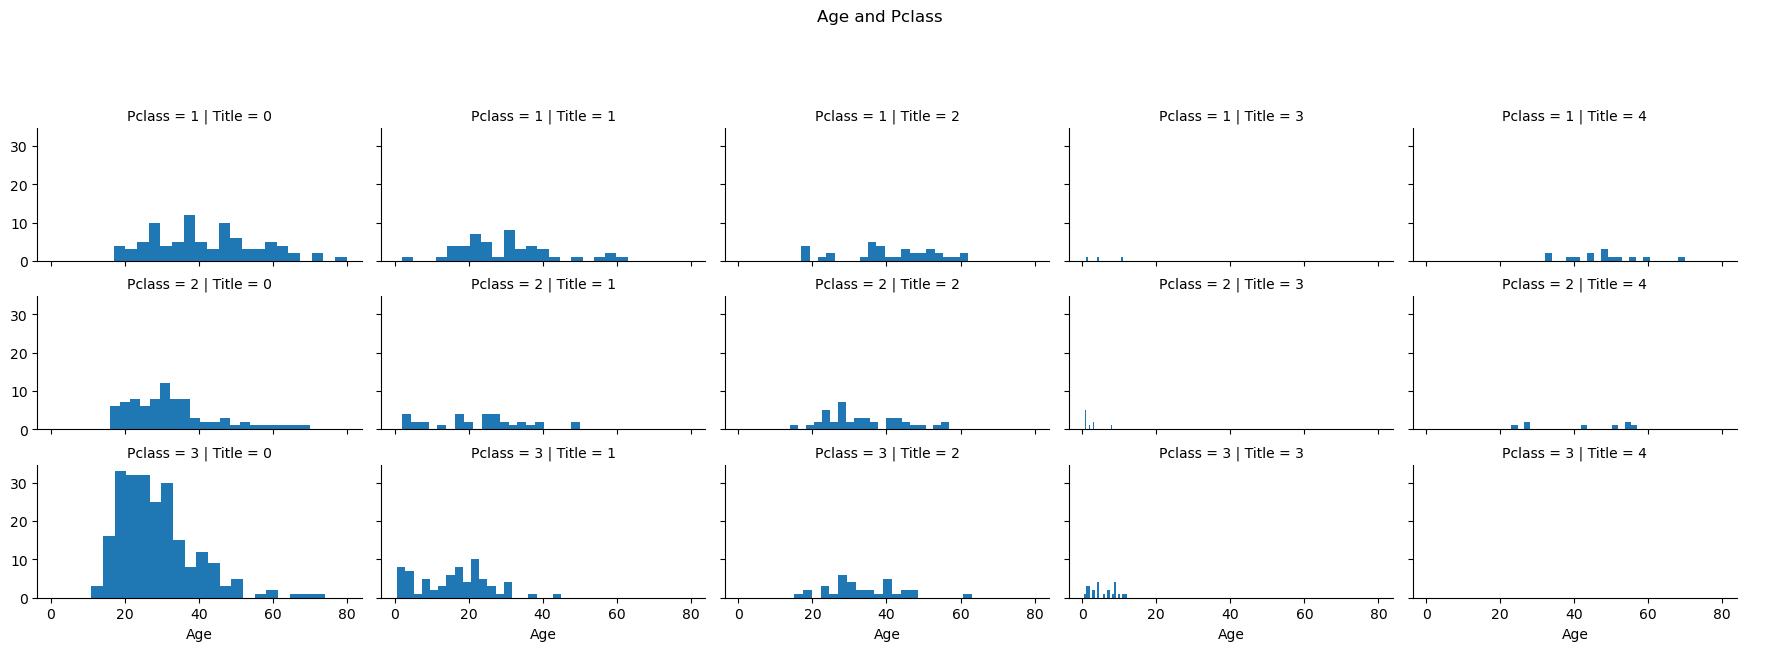

In [13]:
grid = sns.FacetGrid(df_train, row='Pclass',col='Title', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle('Age and Pclass')
grid.add_legend()

We can see the Age columns still exists missin value. We need fill these values to avoid missing value in dataset.

We can fill it with generate random numbers between mean or median and standard deviation. But in this case, we decide to use Pclass and Title feature to predict Age feature of each passenger.

In [14]:
pclass_range = df_train['Pclass'].unique()
title_range = df_train['Title'].unique()
guess_ages = np.zeros((len(pclass_range), len(title_range)))
for pclass in pclass_range:
    for title in title_range:
        df = df_train[(df_train['Pclass'] == pclass) & (df_train['Title'] == title)]['Age'].dropna()
        guess = df.median()
        if pd.isna(guess):
            guess = 0
        guess_ages[pclass - 1, title - 1] = int(guess/0.5 + 0.5 ) * 0.5
        print(f'pclass : {pclass}, title : {title}, median : {guess}')
for pclass in pclass_range:
    for title in title_range:
        df_train.loc[(df_train.Age.isnull()) & (df_train.Pclass == pclass) & (df_train.Title == title), 'Age'] = guess_ages[pclass - 1, title - 1]
        df_test.loc[(df_test.Age.isnull()) & (df_test.Pclass == pclass) & (df_test.Title == title), 'Age'] = guess_ages[pclass - 1, title - 1]
df_train.head()

pclass : 3, title : 0, median : 26.0
pclass : 3, title : 2, median : 31.0
pclass : 3, title : 1, median : 18.0
pclass : 3, title : 3, median : 4.0
pclass : 3, title : 4, median : 0
pclass : 1, title : 0, median : 40.0
pclass : 1, title : 2, median : 40.0
pclass : 1, title : 1, median : 30.0
pclass : 1, title : 3, median : 4.0
pclass : 1, title : 4, median : 48.5
pclass : 2, title : 0, median : 31.0
pclass : 2, title : 2, median : 32.0
pclass : 2, title : 1, median : 24.0
pclass : 2, title : 3, median : 1.0
pclass : 2, title : 4, median : 46.5


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,0
2,1,1,1,38.0,1,0,71.2833,1,2
3,1,3,1,26.0,0,0,7.9250,0,1
4,1,1,1,35.0,1,0,53.1000,0,2
5,0,3,0,35.0,0,0,8.0500,0,0


Convert Numberical features

Convert `Age` continuous to Ordinal features


In [15]:
min_age = df_train['Age'].min()
max_age = df_train['Age'].max()

df_train['AgeBand'] = pd.qcut(df_train['Age'], 5)
print(df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True))

         AgeBand  Survived
0  (0.419, 19.0]  0.497512
1   (19.0, 26.0]  0.242915
2   (26.0, 30.0]  0.406593
3   (30.0, 40.0]  0.447761
4   (40.0, 80.0]  0.364238


In [16]:
for df in [df_train, df_test]:
    df.loc[df['Age'] <= 19, 'Age'] = 0
    df.loc[(df['Age'] > 19) & (df['Age'] <= 26), 'Age'] = 1
    df.loc[(df['Age'] > 26) & (df['Age'] <= 30), 'Age'] = 2
    df.loc[(df['Age'] > 30) & (df['Age'] <= 40), 'Age'] = 3
    df.loc[df['Age'] > 40, 'Age'] = 4
    df['Age'] = df['Age'].astype(int)
df_train = df_train.drop('AgeBand', axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,0,1,1,0,7.2500,0,0
2,1,1,1,3,1,0,71.2833,1,2
3,1,3,1,1,0,0,7.9250,0,1
4,1,1,1,3,1,0,53.1000,0,2
5,0,3,0,3,0,0,8.0500,0,0


Like a `Age` features, we can do the same with the `Fare` features. Convert `Fare` continuous to Ordinal features

In [17]:
df_train['FareBand'] = pd.qcut(df_train['Fare'], 3)
print(df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True))

          FareBand  Survived
0  (-0.001, 8.662]  0.198052
1    (8.662, 26.0]  0.402778
2  (26.0, 512.329]  0.559322


In [18]:
for df in [df_train, df_test]:
    df['Fare'] = df['Fare'].fillna(df_train['Fare'].median())
    df.loc[df['Fare'] <= 8, 'Fare'] = 0
    df.loc[(df['Fare'] > 8) & (df['Fare'] <= 26), 'Fare'] = 1
    df.loc[df['Fare'] > 26, 'Fare'] = 2
    df['Fare'] = df['Fare'].astype(int)
df_train = df_train.drop('FareBand', axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,0,1,1,0,0,0,0
2,1,1,1,3,1,0,2,1,2
3,1,3,1,1,0,0,0,0,1
4,1,1,1,3,1,0,2,0,2
5,0,3,0,3,0,0,1,0,0


To make the problem easier and neater, we will combine the two columns `Parch` and `Sibsp` into one and determine whether the customer is traveling alone or with a relative.

In [19]:
for df in [df_train, df_test]:
    familySize = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[familySize == 1, 'IsAlone'] = 1
df_train = df_train.drop(['SibSp', 'Parch'], axis=1)
df_test = df_test.drop(['SibSp', 'Parch'], axis=1)
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
PassengerId,,,,,,,,
1,0,3,0,1,0,0,0,0
2,1,1,1,3,2,1,2,0
3,1,3,1,1,0,0,1,1
4,1,1,1,3,2,0,2,0
5,0,3,0,3,1,0,0,1


After cleaning dataset, we have some features have a correlation with Survived. We come in to train the model.

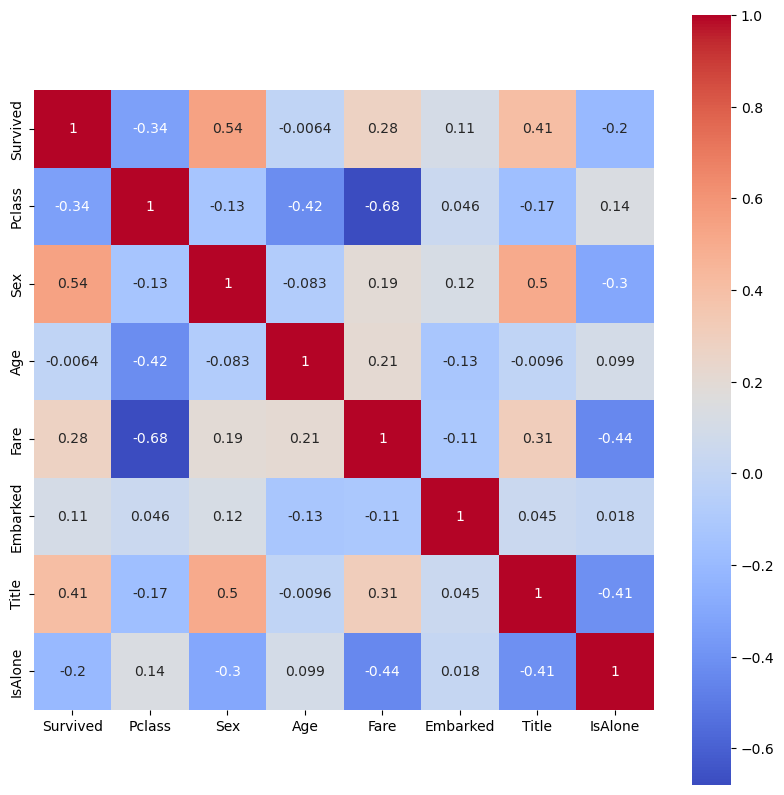

In [20]:
corr = df_train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, cmap='coolwarm')
plt.show()

When we dataset is cleaning with numerical feature, now we can to starting training model.

Data Evolution

Model Training:

KNN: KNN or k-Nearest Neighbors is a non-parametric method used for classification and regression.

Navie Bayes: Naive Bayes Classifier in machine learning is a probabilistic classifier. It predicts on the basis of the probability of an object.

Decision Tree: Decision Tree is a supervised learning algorithm used for classification and regression.

Random Forest: Ramdom Forest is a supervised learning algorithm.

In [21]:
X_train = df_train.drop('Survived', axis=1)
Y_train = df_train['Survived']
X_test = df_test.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
score_knn = accuracy_score(Y_train, knn.predict(X_train))
print(f'KNN score : {score_knn} -> {round(score_knn*100, 2)}%')

KNN score : 0.8406285072951739 -> 84.06%


In [23]:
navie = GaussianNB()
navie.fit(X_train, Y_train)
Y_pred = navie.predict(X_test)
score_naive = accuracy_score(Y_train, navie.predict(X_train))
print(f'Navie score : {score_naive} -> {round(score_naive*100, 2)}%')

Navie score : 0.7710437710437711 -> 77.1%


In [24]:
decision = DecisionTreeClassifier()
decision.fit(X_train, Y_train)
Y_pred = decision.predict(X_test)
score_decision = accuracy_score(Y_train, decision.predict(X_train))
print(f'Decision score : {score_decision} -> {round(score_decision*100, 2)}%')

Decision score : 0.8664421997755332 -> 86.64%


In [25]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
score_rf = accuracy_score(Y_train, rf.predict(X_train))
print(f'Random Forest score : {score_rf} -> {round(score_rf*100, 2)}%')

Random Forest score : 0.8664421997755332 -> 86.64%


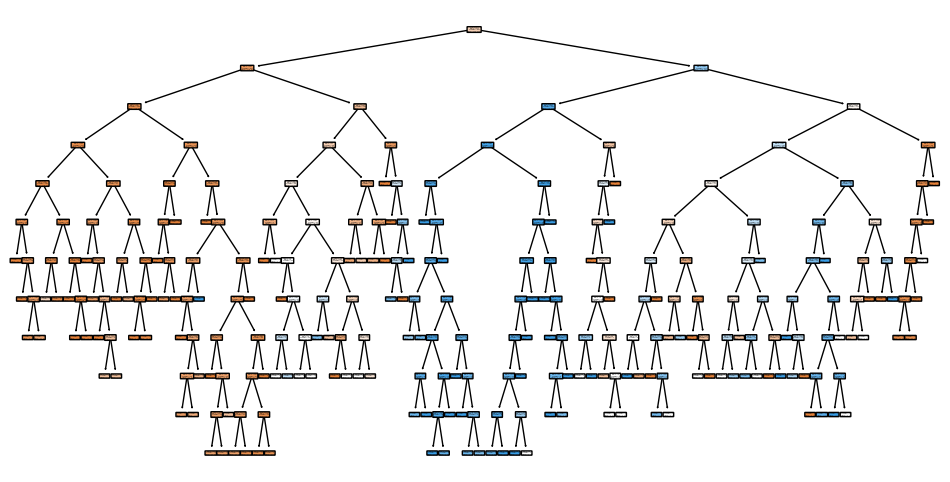

In [26]:
tree = plot_tree(decision, feature_names=list(X_train.columns), filled=True, rounded=True)
tree[0].figure.set_size_inches(12, 6)

In [27]:
cate = ["KNN", "Decision Tree", "Random Forest", "Navie Bayes"]
scores = [score_knn, score_decision, score_rf, score_naive]
for i in range(len(scores)):
    print(f'{cate[i]} score : {scores[i]} -> {round(scores[i]*100, 2)}%')

KNN score : 0.8406285072951739 -> 84.06%
Decision Tree score : 0.8664421997755332 -> 86.64%
Random Forest score : 0.8664421997755332 -> 86.64%
Navie Bayes score : 0.7710437710437711 -> 77.1%


Text(0.5, 1.0, 'Accuracy of models')

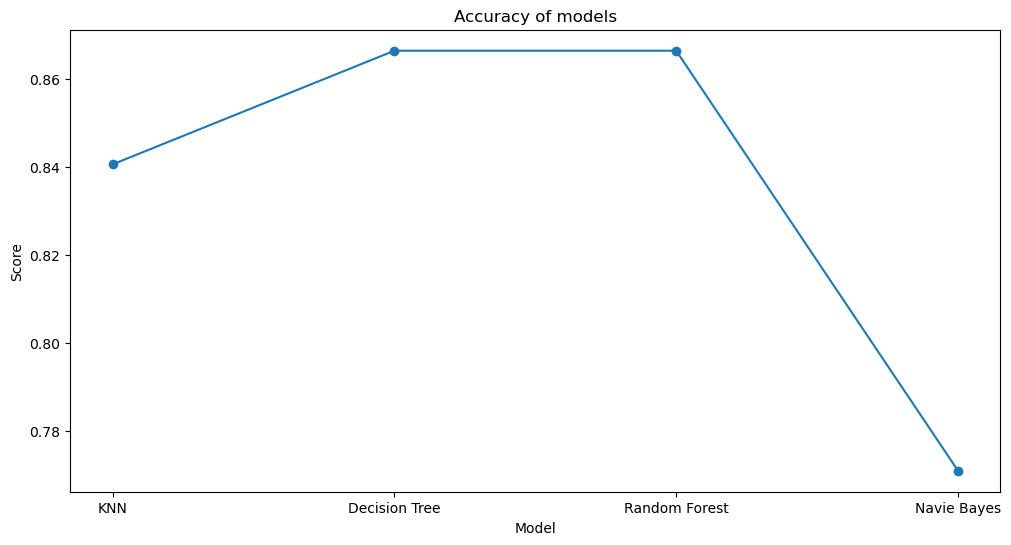

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cate, scores, marker='o')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Accuracy of models')

In [29]:
lgt_model = LogisticRegression()
lgt_model.fit(X_train, Y_train)

Y_pred = lgt_model.predict(X_test)
score_lgt = accuracy_score(Y_train, lgt_model.predict(X_train))
print(f'Logistic Regression score : {score_lgt} -> {round(score_lgt*100, 2)}%')

Logistic Regression score : 0.8024691358024691 -> 80.25%
